<a href="https://colab.research.google.com/github/CJWhyte/NeuromatchProject/blob/main/DataForPlasticityProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script extracts the following data from the Allen Brain Institute dataset: 

*   Inhibitory (SST and VIP) and excitatory cells
*   Passive viewing of familair and novel stim
*   0-600ms
*   Single scope recording

Note. During the 2-photon imaging portion of the experiment, mice perform the task with the same set of images they saw during training (either image set A or B), as well as an additional novel set of images (whichever of A or B that they did not see during training). This allows evaluation of the impact of different sensory contexts on neural activity - familiarity versus novelty. Sessions with familiar images include those starting with OPHYS_0, OPHYS_1, OPHYS_2, and OPHYS_3. Sessions with novel images include those starting with OPHYS_4, OPHYS_5, and OPHYS_6. To recap:

**Familiar**
*   OPHYS_0, OPHYS_1, OPHYS_2, and OPHYS_3

**Novel**
*   OPHYS_4, OPHYS_5, and OPHYS_6.


Interleaved between active behavior sessions are passive viewing sessions where mice are given their daily water ahead of the sesssion (and are thus satiated) and view the stimulus with the lick spout retracted so they are unable to earn water rewards. This allows comparison of neural activity in response to stimuli under different behavioral context - active task engagement and passive viewing without reward. Passive sessions include OPHYS_2_images_A_passive (passive session with familiar images), and OPHYS_5_images_A_passive (passive session with novel images). To recap:

**Passive: Familiar**
*   OPHYS_2_images_A_passive

**Passive: Novel**
*   OPHYS_5_images_A_passive

**These are the two sessions that we need!**

Load necessary packages. Make sure to click restart runtime to get package to work

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

load packages

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

load summary tables

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.03MMB/s] 
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 4.92MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.03MMB/s] 


`Ophys_session_table`


contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.

`Behavior_session_table `

ontains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.

`Ophys_experiment_table`

contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the ophys_container_id column that can be found in both ophys_session_table and ophys_experiment_table.

**We show all three tables below**

In [4]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We now view the contents of each table 

In [5]:
session_table.session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B',
       'OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_6_images_A', 'OPHYS_5_images_A_passive'],
      dtype=object)

We want OPHYS_2_images_A_passive (familair) and OPHYS_5_images_A_passive (novel)


In [6]:
experiment_table.session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B',
       'OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_6_images_A', 'OPHYS_5_images_A_passive'],
      dtype=object)

With the conditions of each session listed above we need more information about cell type and column names in the data which we get below

In [7]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


In [8]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


We are now going to load data from a single passive viewing session using the session id listed above when the animal has seen the image 66 times before so it is a FAMILIAR session

In [9]:
ophys_session_id_familiar = 952430817
session_table.loc[ophys_session_id_familiar]

equipment_name                                                               MESO.1
full_genotype                         Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                     457841
reporter_line                                            Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                          [Sst-IRES-Cre]
sex                                                                               F
age_in_days                                                                     209
cre_line                                                               Sst-IRES-Cre
indicator                                                                   GCaMP6f
session_number                                                                    2
prior_exposures_to_session_type                                                   0
prior_exposures_to_image_set                                                

We now download all of the experiments associated with this session ID

In [10]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id_familiar]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_953659743.nwb: 100%|██████████| 252M/252M [00:20<00:00, 12.4MMB/s]
behavior_ophys_experiment_953659745.nwb: 100%|██████████| 247M/247M [00:12<00:00, 19.3MMB/s]
behavior_ophys_experiment_953659749.nwb: 100%|██████████| 261M/261M [00:13<00:00, 20.0MMB/s]
behavior_ophys_experiment_953659752.nwb: 100%|██████████| 256M/256M [00:14<00:00, 17.8MMB/s]


For this familiar session we will now load all of the associated experiments into memory

In [11]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 4/4 [00:21<00:00,  5.37s/it]


With the neural data now in memory we can inspect column labels

In [12]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.60844,0.424997,0.0,0.0,1080739705,1086622595,953659743,952430817,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
1,9.70165,0.279344,0.0,0.0,1080739705,1086622595,953659743,952430817,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
2,9.79486,0.029540,0.0,0.0,1080739705,1086622595,953659743,952430817,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
3,9.88807,-0.035826,0.0,0.0,1080739705,1086622595,953659743,952430817,VISp,225,MESO.1,Sst-IRES-Cre,457841,F
4,9.98128,0.044807,0.0,0.0,1080739705,1086622595,953659743,952430817,VISp,225,MESO.1,Sst-IRES-Cre,457841,F


We now need to grab the IDs for specific cells

In [13]:
cell_ids = neural_data['cell_specimen_id'].unique()

With the neural data now in memory we load the associated stimulus data

In [14]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25023,18002.0,0,im065,0,False,17987,309.65357,309.90380,False
1,0.25000,NaN,8,omitted,0,True,18031,310.38755,310.63755,False
2,0.25021,18092.0,0,im065,1,False,18077,311.15483,311.40504,False
3,0.25019,18137.0,0,im065,2,False,18122,311.90545,312.15564,False
4,0.25020,18182.0,3,im061,3,False,18167,312.65605,312.90625,True
5,0.25019,18227.0,3,im061,4,False,18212,313.40666,313.65685,False
6,0.25013,18272.0,3,im061,5,False,18257,314.15735,314.40748,False
7,0.25020,18317.0,3,im061,6,False,18302,314.90789,315.15809,False
8,0.25019,18362.0,3,im061,7,False,18347,315.65850,315.90869,False


Okay. We are now going to use the mindscope_utilities function to create an event related time series for our session of interest in a specific cell. 

In [15]:
cell_id = cell_ids[11]
celltype= 'Sst-IRES-Cre'
etr = mindscope_utilities.event_triggered_response(
    neural_data.query('cell_specimen_id == @cell_id and cre_line == @celltype'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('is_change')['start_time'],
    t_before=0, # 0ms
    t_after=.6, # 600ms
    output_sampling_rate = 100,
)
etr

,time,dff,event_number,event_time
0,0.00,0.202468,0,312.65605
1,0.01,0.202468,0,312.65605
2,0.02,0.202468,0,312.65605
3,0.03,0.202468,0,312.65605
4,0.04,0.197763,0,312.65605
...,...,...,...,...
21711,0.56,-0.104252,355,3910.89639
21712,0.57,-0.103097,355,3910.89639
21713,0.58,-0.103055,355,3910.89639
21714,0.59,-0.103055,355,3910.89639


Yay! Lets generate our first plot. To recap this is an average response for an SST cell (inhibitory interneuron) from 0 to 600ms post stimulus onset in a passive session with image set A

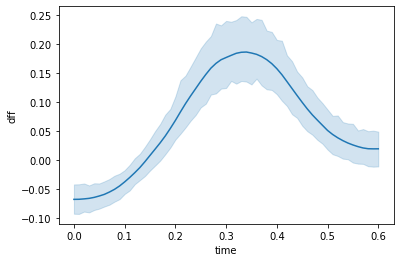

In [16]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

NOTE TO SELF we have loaded the data, the stimulus info and have the cell ids we now just need to use the **bold text**